In [355]:
import os
import re
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from transformers import BertTokenizer


In [356]:
# Map src directory
import sys
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), "../."))
print("Root Directory: ", root_dir)
src_dir = os.path.join(root_dir,"src")
print("Src Directory: ", src_dir)
sys.path.append(src_dir)
data_dir = os.path.join(root_dir,"data")
print("Data Directory: ", data_dir)

Root Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder
Src Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/src
Data Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/data


In [357]:
# Step 1: Load CSV Files
gcat_path = os.path.join(data_dir,"raw","gcat","20240924-2136-gcat-results.csv")
gcat_df = pd.read_csv(gcat_path)


/tmp/ipykernel_21099/896415136.py:3: DtypeWarning: Columns (50,54,61,62,64,68,70) have mixed types. Specify dtype option on import or set low_memory=False.
  gcat_df = pd.read_csv(gcat_path)


In [358]:
# gcat_df[['YEAR','LOCAL_REPORT_NUMBER_ID']]
import re
import pandas as pd

def clean_cad_id(year, id_num):
    """
    Clean and standardize the CAD_ID based on predefined patterns.
    
    Parameters:
    year (str): The year associated with the record.
    id_num (str): The original ID number to be cleaned.
    
    Returns:
    str: The cleaned and standardized CAD_ID.
    """
    patterns = {
        "year-hyphen": r'^\d{4}-\d{5,}',
        "year_no_hyphen": r'^\d{10}$',
        "2digit-year-hyphen": r'^\d{2}-\d{5,}',
        "special": r'^\d{2}-\d{4}-\d{2}',
        "miscellaneous": r'.+',
        "rpt_num_only": r'^\d{5,}'
    }

    if pd.isna(id_num):
        return None  # Return None for missing or NaN values

    id_num = str(id_num)  # Ensure id_num is a string

    if re.match(patterns["year-hyphen"], id_num):
        parts = id_num.split("-", 1)
        new_id = parts[0] + parts[1].zfill(8)  # Pad second part to 5 digits
    elif re.match(patterns["year_no_hyphen"], id_num):
        
        part1 = id_num[:4] 
        part2 = id_num[4:]
        print(part1,part2)
        new_id = part1 + part2.zfill(8)
    elif re.match(patterns["2digit-year-hyphen"], id_num):
        parts = id_num.split("-", 1)
        new_id = parts[0] + parts[1].zfill(8)  # Prepend '20' and pad to 5 digits
    elif re.match(patterns["rpt_num_only"], id_num):
        new_id = year + id_num.zfill(8)  # Concatenate year and padded ID
    elif re.match(patterns["special"], id_num):
        new_id = id_num.replace("-", "")  # Remove hyphens
    else:
        new_id = id_num.replace("-", "")  # Remove hyphens for miscellaneous cases

    return new_id

# Example usage with a DataFrame
# Assuming gcat_df is your DataFrame and 'CRASH_YR' and 'LOCAL_REPORT_NUMBER_ID' are the relevant columns
gcat_df['YEAR'] = gcat_df['CRASH_YR'].astype(str).str[:4]
gcat_df['CAD_ID'] = gcat_df.apply(lambda row: clean_cad_id(row['YEAR'], row['LOCAL_REPORT_NUMBER_ID']), axis=1)

gcat_df['INTERSECTION_IND'] = np.where(gcat_df['INTERSECTION_ID_CURRENT'].notnull(), 'Y', 'N')



2023 174944
2023 235152
2023 232448
2023 233804
2023 336968
2023 170312
2023 173699
2023 185702
2023 188523
2023 174341
2023 188782
2023 173557
2023 166094
2023 175133
2023 177524
2023 173406
2023 173593
2023 173923
2023 178362
2023 178641
2023 179660
2023 179789
2023 213058
2023 237435
2023 214360
2023 074771
2023 057170
2023 076308
2023 070779
2023 064025
2023 056433
2023 070204
2023 251536
2023 247615
2023 216776
2023 173449
2023 172489
2023 319365
2023 069805
2023 068082
2023 258243
2023 233868
2023 226462
2023 237403
2023 134628
2023 240224
2023 169219
2023 168289
2023 168743
2023 149436
2023 168181
2023 211437
2023 221725
2023 068978
2023 073003
2023 063379
2023 001155
2023 332893
2023 173832
2023 172811
2023 334579
2023 333052
2023 346090
2023 348743
2023 084685
2023 093510
2023 069755
2023 091074
2023 088582
2023 072419
2023 228590
2023 284434
2023 159141
2023 167954
2023 173804
2023 154404
2023 265245
2023 265272
2023 208090
2023 224946
2023 203598
2023 161550
2023 237342
2023

In [359]:
gcat_df[gcat_df['CAD_ID']=='2023385727']
# gcat_df[gcat_df['LOCAL_REPORT_NUMBER_ID']=='2023385727']
# 2023385727

,OBJECTID,DOCUMENT_NBR,CRASH_REPORT_LINK,CRASH_YR,CRASH_MONTH_YEAR,DISTRICT_NBR,NLFID,NLF_JUR_CD,NLF_COUNTY_CD,COUNTY_LOG_NBR,ODOT_LATITUDE_NBR,ODOT_LONGITUDE_NBR,ODOT_FIPS_CD,AREA_CODE,CRASH_DATE,CRASH_SEVERITY_CD,CRASH_TYPE_CD,DAY_IN_WEEK_CD,DISTRACTED_DRIVER_IND,FACILITY_TYPE_CD,FHWA_RDWY_DEPARTURE_IND,FREEWAY_IND,FUNCTIONAL_CLASS_CD,HOUR_OF_CRASH,INCAPAC_INJURIES_NBR,INTERCHANGE_ID,INTERSECTION_ID_CURRENT,INTERSECTION_LEG_ID,INTERSTATE_IND,INV_LOG_NBR,INV_NLFID,IS_COMMERCIAL_RELATED,LIGHT_COND_PRIMARY_CD,LOCAL_REPORT_NUMBER_ID,MAINTENANCE_AUTHORITY_CD,MONTH_OF_CRASH,NHS_CD,NO_INJURY_REPORTED_NBR,NON_INCAPAC_INJURIES_NBR,NUMBER_OF_UNITS_NBR,ODOT_CITY_VILLAGE_TWP_NME,ODOT_CRASH_LOCATION_CD,ODOT_DIR_FROM_REF_CD,ODOT_DIV_UNDIV_IND,ODOT_INTERSECTION_REL_IND,ODOT_LANES_NBR,ODOT_MAINTAINED_HWY_IND,ODOT_MILES_FROM_REF_NBR,ODOT_REF_ROUTE_PREFIX_CD,ODOT_YOUNG_DRIVER_IND,ODPS_ADDRESS_REFERENCE,ODPS_ALCOHOL_IND,ODPS_CITY_VILLAGE_TWP_NME,ODPS_DRUG_IND,ODPS_LOC_DIR_SUFFIX_CD,ODPS_LOC_IN_WORK_ZONE_CD,ODPS_LOC_ROAD_DIRECTION_CD,ODPS_LOC_ROAD_NME,ODPS_LOC_ROAD_SUFFIX_CD,ODPS_LOC_ROUTE_ID,ODPS_LOC_ROUTE_PREFIX_CD,ODPS_LOC_ROUTE_SUFFIX_CD,ODPS_MILEPOST_REFERENCE,ODPS_MOTORCYCLE_IND,ODPS_REF_DIR_SUFFIX_CD,ODPS_REF_DIRECTION_CD,ODPS_REF_GIVEN,ODPS_REF_POINT_USED_CD,ODPS_REF_ROUTE_ID,ODPS_REF_ROUTE_PREFIX_CD,ODPS_REF_ROUTE_SUFFIX_CD,ODPS_REF_SUFFIX_CD,ODPS_SCHOOL_ZONE_IND,ODPS_SENIOR_DRIVER_IND,ODPS_SPEED_IND,ODPS_TOTAL_FATALITIES_NBR,ODPS_TYPE_OF_WORK_ZONE_CD,ODPS_WORK_ZONE_IND,OPER_ACCESS_CONTROL_CD,POSSIBLE_INJURIES_NBR,ROAD_COND_PRIMARY_CD,ROAD_CONTOUR_CD,SA_RAMP_ID,SA_SEGMENT_ID,SECONDARY_CRASH,STATE_TRUE_LOG_NBR,U1_AGE_NBR,U1_AT_FAULT_IND,U1_CONT_CIR_PRIMARY_CD,U1_DIRECTION_FROM_CD,U1_DIRECTION_TO_CD,U1_DISTRACTED_BY_1_CD,U1_GENDER_CD,U1_IS_ALCOHOL_SUSPECTED,U1_IS_MARIJUANA_SUSPECTED,U1_IS_OTHER_DRUG_SUSPECTED,U1_NON_MOTORIST_LOC_CD,U1_NUMBER_OF_THRU_LANES,U1_OBJECT_STRUCK,U1_ODPS_UNIT_NBR,U1_OPERATINGIN_AUTONOMOUS_MODE,U1_POSTED_SPEED_NBR,U1_PRECRASH_ACTION_CD,U1_SEQ_OF_EVENTS_1_CD,U1_SEQ_OF_EVENTS_2_CD,U1_SEQ_OF_EVENTS_3_CD,U1_SEQ_OF_EVENTS_4_CD,U1_SEQ_OF_EVENTS_5_CD,U1_SEQ_OF_EVENTS_6_CD,U1_SPECIAL_FUNCTION_CD,U1_TRAFFIC_CONTROL_CD,U1_TURN_CD,U1_TYPE_OF_UNIT_CD,U1_UNIT_SPEED_NBR,U2_AGE_NBR,U2_CONT_CIR_PRIMARY_CD,U2_DIRECTION_FROM_CD,U2_DIRECTION_TO_CD,U2_DISTRACTED_BY_1_CD,U2_GENDER_CD,U2_NON_MOTORIST_LOC_CD,U2_ODPS_UNIT_NBR,U2_POSTED_SPEED_NBR,U2_PRECRASH_ACTION_CD,U2_SEQ_OF_EVENTS_1_CD,U2_SEQ_OF_EVENTS_2_CD,U2_SEQ_OF_EVENTS_3_CD,U2_SEQ_OF_EVENTS_4_CD,U2_SEQ_OF_EVENTS_5_CD,U2_SEQ_OF_EVENTS_6_CD,U2_SPECIAL_FUNCTION_CD,U2_TRAFFIC_CONTROL_CD,U2_TURN_CD,U2_TYPE_OF_UNIT_CD,U2_UNIT_SPEED_NBR,U3_CONT_CIR_PRIMARY_CD,U3_ODPS_UNIT_NBR,U3_PRECRASH_ACTION_CD,U3_SEQ_OF_EVENTS_1_CD,U3_SEQ_OF_EVENTS_2_CD,U3_SEQ_OF_EVENTS_3_CD,U3_SEQ_OF_EVENTS_4_CD,U3_SEQ_OF_EVENTS_5_CD,U3_SEQ_OF_EVENTS_6_CD,U3_SPECIAL_FUNCTION_CD,U3_TRAFFIC_CONTROL_CD,U3_TYPE_OF_UNIT_CD,UNRESTRAIN_OCCUPANTS,WEATHER_COND_CD,YEAR,CAD_ID,INTERSECTION_IND


In [360]:
bikecle_labels_path = os.path.join(data_dir,"raw","bike_cle_narratives","callsforservice-quoted.csv")
bikecle_label_df = pd.read_csv(bikecle_labels_path)
bikecle_label_df.rename(columns={'event_number': 'CAD_ID', 'narrative':'BIKE_CLE_TEXT'}, inplace=True)
bikecle_label_df['CAD_ID'] = bikecle_label_df['CAD_ID'].astype(str)

/tmp/ipykernel_21099/4123855356.py:2: DtypeWarning: Columns (1,11,16,20,21,22,24,28,29,30,31,34,38,39,42,45,46,48,49,55,56,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  bikecle_label_df = pd.read_csv(bikecle_labels_path)


In [361]:
bikecle_label_df[bikecle_label_df['CAD_ID']=='202000004207']

,primarykey,agency,CAD_ID,rev_num,call_datetime,call_type,call_desc,primary_unit,priority,call_source,cvaddress,cvaddress_zip,apt,zip,x_coord,y_coord,current_flag,cvcalldate,cvcalldow,cvcalltime,cvlegend,iwgeoname,status,score,side,x,y,cv_districts,arrival_datetime,sub_call_type,nature,pd_zone,pd_district,dispo_desc,cv_zones,cv_spa,dispo_desc_final,wkb_geometry,update_datetime,event_status,pd_ward,cv_wards,cmc_case_no,cmc_case_notes,local_report_no,BIKE_CLE_TEXT,assigned,objectid,notes_misc,orig_call_desc,cad_notes_status,call911_status,bluecam_status,wcs_status,oh1_status,countermeasures,victim,oshpoh1id,duplicate_of,is_motorcycle,ytids
157930,NaN,NaN,202000004207,NaN,2020-01-05 05:04:23+00,NFP,NON FATAL ACCIDENT - PEDESTRIAN STRUCK,4D32,2.0,1234,WARNER RD & WEBB TER,NaN,NaN,44105.0,NaN,NaN,NaN,20200105,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,D4,"OH1, TOW",411,Broadway-Slavic Village,TOW,0101000000ACD0F69E006854C0C2E50C20D7B84440,NaN,NaN,NaN,2.0,NaN,NaN,2.020000e+11,A driver of an SUV struck an adult and a passe...,"{""Willis, Tony""}",NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,2.020404e+10,NaN,NaN,NaN


In [362]:
# Step 2: Read Text Files
def read_text_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()

In [363]:
cad_text_dict = {}
oh1_text_dict = {}
cad_image_dir = os.path.join(data_dir, "processed", "cad_images")
oh1_image_dir = os.path.join(data_dir, "processed", "oh1_images")
def load_text_into_dict(image_dir,dir_name):
    with ThreadPoolExecutor() as executor:
        folder_paths = [os.path.join(image_dir, folder) for 
                        folder in os.listdir(image_dir) 
                        if os.path.isdir(os.path.join(image_dir, folder))]
        file_paths = []
        for folder in folder_paths:
            for file in os.listdir(folder):
                if file.endswith('.txt'):
                    file_paths.append(os.path.join(folder, file))
        results = executor.map(read_text_file, file_paths)
        for file_path, content in zip(file_paths, results):
            incident_id = os.path.basename(file_path).split('.')[0]
            dir_name[incident_id] = content

load_text_into_dict(cad_image_dir,cad_text_dict)
load_text_into_dict(oh1_image_dir,oh1_text_dict)

cad_text_df = pd.DataFrame(cad_text_dict.items(), columns=['CAD_ID', 'CAD_TEXT'])
def remove_extra_cad_chars(cad_id):
    return cad_id[:12]
cad_text_df['CAD_ID'] = cad_text_df['CAD_ID'].apply(remove_extra_cad_chars)

oh1_text_df = pd.DataFrame(oh1_text_dict.items(), columns=['CAD_ID', 'OH1_TEXT'])
def remove_extra_oh1_chars(cad_id):
    return "20" + cad_id[16:]
oh1_text_df['CAD_ID'] = oh1_text_df['CAD_ID'].apply(remove_extra_oh1_chars)

In [364]:
oh1_text_df.head()

,CAD_ID,OH1_TEXT
0,202100231011,MOTHER OF VICTIM STATED THAT HER 6 YEAR-OLD DA...
1,202000001607,"WHILE UNIT1 WAS TURNING ONTO W44_, PEDESTRIAN ..."
2,202000002644,(JNIT 1 IS S/B ON E.99 STREET TURNING E/B (LEF...
3,202000003892,E : UNIT #1 WAS DRIVING EASTBOUND ACROSS W117 ...
4,202000004207,OWNER OF UNIT #1 STATED SHE WAS OUTSIDE OF HER...


In [365]:
bikecle_label_df.head()

,primarykey,agency,CAD_ID,rev_num,call_datetime,call_type,call_desc,primary_unit,priority,call_source,cvaddress,cvaddress_zip,apt,zip,x_coord,y_coord,current_flag,cvcalldate,cvcalldow,cvcalltime,cvlegend,iwgeoname,status,score,side,x,y,cv_districts,arrival_datetime,sub_call_type,nature,pd_zone,pd_district,dispo_desc,cv_zones,cv_spa,dispo_desc_final,wkb_geometry,update_datetime,event_status,pd_ward,cv_wards,cmc_case_no,cmc_case_notes,local_report_no,BIKE_CLE_TEXT,assigned,objectid,notes_misc,orig_call_desc,cad_notes_status,call911_status,bluecam_status,wcs_status,oh1_status,countermeasures,victim,oshpoh1id,duplicate_of,is_motorcycle,ytids
0,8393467.0,CPD,202300352769,2.0,2023-11-22 11:17:55+00,INFW,INFO FOR A WARRANT PICK UP,NaN,4.0,ANI/ALI,W 25TH ST & DENISON AVE,"W 25TH ST & DENISON AVE ,",NaN,NaN,218732800.0,65098043.0,T,20231122,3.0,117,WARRANT,CAD911_CWDSA_Streets,M,100.0,R,2.187328e+06,650980.426713,2.0,NaN,2M,NaN,26,D9,CR,2-6,Brooklyn Centre,CR,010100000000F1A952E96C54C09F06674BB1B94440,NaN,C,14.0,14.0,NaN,NaN,NaN,NaN,NaN,10719719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8393469.0,CPD,202300352770,2.0,2023-11-22 11:20:46+00,TRUN,TROUBLE - UNKNOWN CAUSE,NaN,2.0,ANI/ALI,13800 SHAKER BLVD,"13800 SHAKER BLVD ,",NaN,NaN,221905603.0,66308540.0,T,20231122,3.0,120,OTHER,CAD911_CWDSA_Streets,M,100.0,R,2.218888e+06,663135.667116,4.0,NaN,2M,NaN,45,D4,CC,4-5,Buckeye-Shaker Square,CC,01010000009F758D96836554C0A8F3F285DABD4440,NaN,C,4.0,4.0,NaN,NaN,NaN,NaN,NaN,10719720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8393470.0,CPD,202300352771,2.0,2023-11-22 11:22:19+00,RFS,REC FILE SECTION EVENT- (RFS USE ONLY),NaN,5.0,Phone,4924 PEARL RD,"4924 PEARL RD , 44144",NaN,44144.0,218174402.0,64117552.0,T,20231122,3.0,122,OTHER,CAD911_CWDSA_Streets_nozip,M,100.0,R,2.181671e+06,641007.333930,2.0,NaN,1M,NaN,27,D2,REPT,2-7,Old Brooklyn,REPT,010100000080715FBD406E54C0744A9B0535B64440,NaN,C,NaN,13.0,NaN,NaN,NaN,NaN,NaN,10719721.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8393471.0,CPD,202300352772,8.0,2023-11-22 11:22:33+00,CWEL,CHECK WELFARE OF A PERSON,2A37,2.0,ANI/ALI,1026 W SCHAAF RD,"1026 W SCHAAF RD ,",UP,NaN,219140791.0,64182827.0,T,20231122,3.0,122,OTHER,CAD911_CWDSA_Streets,M,100.0,R,2.191671e+06,641632.189973,2.0,NaN,2M,NaN,27,D2,NR,2-7,Old Brooklyn,NR,01010000009ADD49FAEA6B54C0E417B90265B64440,NaN,A,12.0,12.0,NaN,NaN,NaN,NaN,NaN,10719722.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8393472.0,CPD,202300352773,9.0,2023-11-22 11:22:51+00,SPOT,SHOTSPOTTER ALERT,4A34,1.0,NaN,3595 E 49TH ST,"3595 E 49TH ST , 44105",NaN,44105.0,219964677.0,65449370.0,T,20231122,3.0,122,OTHER,CAD911_CWDSA_Streets,M,100.0,L,2.199686e+06,654512.790686,4.0,2023-11-22 01:30:21,2M,NaN,41,D4,"TOUR, GOA, UTL",4-1,Broadway-Slavic Village,UTL,01010000005D24A3B9046A54C03E7AC37DE4BA4440,NaN,A,12.0,12.0,NaN,NaN,NaN,NaN,NaN,10719723.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [366]:
from IPython.display import display, HTML

# Ensure all columns are displayed
pd.set_option('display.max_columns', None)

# Display the DataFrame in a scrollable div
display(HTML(gcat_df.head().to_html(classes='table table-striped table-hover', max_rows=5)))

,OBJECTID,DOCUMENT_NBR,CRASH_REPORT_LINK,CRASH_YR,CRASH_MONTH_YEAR,DISTRICT_NBR,NLFID,NLF_JUR_CD,NLF_COUNTY_CD,COUNTY_LOG_NBR,ODOT_LATITUDE_NBR,ODOT_LONGITUDE_NBR,ODOT_FIPS_CD,AREA_CODE,CRASH_DATE,CRASH_SEVERITY_CD,CRASH_TYPE_CD,DAY_IN_WEEK_CD,DISTRACTED_DRIVER_IND,FACILITY_TYPE_CD,FHWA_RDWY_DEPARTURE_IND,FREEWAY_IND,FUNCTIONAL_CLASS_CD,HOUR_OF_CRASH,INCAPAC_INJURIES_NBR,INTERCHANGE_ID,INTERSECTION_ID_CURRENT,INTERSECTION_LEG_ID,INTERSTATE_IND,INV_LOG_NBR,INV_NLFID,IS_COMMERCIAL_RELATED,LIGHT_COND_PRIMARY_CD,LOCAL_REPORT_NUMBER_ID,MAINTENANCE_AUTHORITY_CD,MONTH_OF_CRASH,NHS_CD,NO_INJURY_REPORTED_NBR,NON_INCAPAC_INJURIES_NBR,NUMBER_OF_UNITS_NBR,ODOT_CITY_VILLAGE_TWP_NME,ODOT_CRASH_LOCATION_CD,ODOT_DIR_FROM_REF_CD,ODOT_DIV_UNDIV_IND,ODOT_INTERSECTION_REL_IND,ODOT_LANES_NBR,ODOT_MAINTAINED_HWY_IND,ODOT_MILES_FROM_REF_NBR,ODOT_REF_ROUTE_PREFIX_CD,ODOT_YOUNG_DRIVER_IND,ODPS_ADDRESS_REFERENCE,ODPS_ALCOHOL_IND,ODPS_CITY_VILLAGE_TWP_NME,ODPS_DRUG_IND,ODPS_LOC_DIR_SUFFIX_CD,ODPS_LOC_IN_WORK_ZONE_CD,ODPS_LOC_ROAD_DIRECTION_CD,ODPS_LOC_ROAD_NME,ODPS_LOC_ROAD_SUFFIX_CD,ODPS_LOC_ROUTE_ID,ODPS_LOC_ROUTE_PREFIX_CD,ODPS_LOC_ROUTE_SUFFIX_CD,ODPS_MILEPOST_REFERENCE,ODPS_MOTORCYCLE_IND,ODPS_REF_DIR_SUFFIX_CD,ODPS_REF_DIRECTION_CD,ODPS_REF_GIVEN,ODPS_REF_POINT_USED_CD,ODPS_REF_ROUTE_ID,ODPS_REF_ROUTE_PREFIX_CD,ODPS_REF_ROUTE_SUFFIX_CD,ODPS_REF_SUFFIX_CD,ODPS_SCHOOL_ZONE_IND,ODPS_SENIOR_DRIVER_IND,ODPS_SPEED_IND,ODPS_TOTAL_FATALITIES_NBR,ODPS_TYPE_OF_WORK_ZONE_CD,ODPS_WORK_ZONE_IND,OPER_ACCESS_CONTROL_CD,POSSIBLE_INJURIES_NBR,ROAD_COND_PRIMARY_CD,ROAD_CONTOUR_CD,SA_RAMP_ID,SA_SEGMENT_ID,SECONDARY_CRASH,STATE_TRUE_LOG_NBR,U1_AGE_NBR,U1_AT_FAULT_IND,U1_CONT_CIR_PRIMARY_CD,U1_DIRECTION_FROM_CD,U1_DIRECTION_TO_CD,U1_DISTRACTED_BY_1_CD,U1_GENDER_CD,U1_IS_ALCOHOL_SUSPECTED,U1_IS_MARIJUANA_SUSPECTED,U1_IS_OTHER_DRUG_SUSPECTED,U1_NON_MOTORIST_LOC_CD,U1_NUMBER_OF_THRU_LANES,U1_OBJECT_STRUCK,U1_ODPS_UNIT_NBR,U1_OPERATINGIN_AUTONOMOUS_MODE,U1_POSTED_SPEED_NBR,U1_PRECRASH_ACTION_CD,U1_SEQ_OF_EVENTS_1_CD,U1_SEQ_OF_EVENTS_2_CD,U1_SEQ_OF_EVENTS_3_CD,U1_SEQ_OF_EVENTS_4_CD,U1_SEQ_OF_EVENTS_5_CD,U1_SEQ_OF_EVENTS_6_CD,U1_SPECIAL_FUNCTION_CD,U1_TRAFFIC_CONTROL_CD,U1_TURN_CD,U1_TYPE_OF_UNIT_CD,U1_UNIT_SPEED_NBR,U2_AGE_NBR,U2_CONT_CIR_PRIMARY_CD,U2_DIRECTION_FROM_CD,U2_DIRECTION_TO_CD,U2_DISTRACTED_BY_1_CD,U2_GENDER_CD,U2_NON_MOTORIST_LOC_CD,U2_ODPS_UNIT_NBR,U2_POSTED_SPEED_NBR,U2_PRECRASH_ACTION_CD,U2_SEQ_OF_EVENTS_1_CD,U2_SEQ_OF_EVENTS_2_CD,U2_SEQ_OF_EVENTS_3_CD,U2_SEQ_OF_EVENTS_4_CD,U2_SEQ_OF_EVENTS_5_CD,U2_SEQ_OF_EVENTS_6_CD,U2_SPECIAL_FUNCTION_CD,U2_TRAFFIC_CONTROL_CD,U2_TURN_CD,U2_TYPE_OF_UNIT_CD,U2_UNIT_SPEED_NBR,U3_CONT_CIR_PRIMARY_CD,U3_ODPS_UNIT_NBR,U3_PRECRASH_ACTION_CD,U3_SEQ_OF_EVENTS_1_CD,U3_SEQ_OF_EVENTS_2_CD,U3_SEQ_OF_EVENTS_3_CD,U3_SEQ_OF_EVENTS_4_CD,U3_SEQ_OF_EVENTS_5_CD,U3_SEQ_OF_EVENTS_6_CD,U3_SPECIAL_FUNCTION_CD,U3_TRAFFIC_CONTROL_CD,U3_TYPE_OF_UNIT_CD,UNRESTRAIN_OCCUPANTS,WEATHER_COND_CD,YEAR,CAD_ID,INTERSECTION_IND
0,248079714.0,2.024808e+10,https://hsip.dot.state.oh.us/api/report/20248079714,2024.0,5/1/2024 12:00:00 AM,12.0,MCUYMR02491**C,M,CUY,0.162,41.501785,-81.683243,16000.0,17668.0,5/9/2024 2:55:00 AM,5.0,13.0,5.0,N,NaN,Y,N,5.0,2.0,0.0,NaN,564c2d35-2f92-441d-91be-c26dad403073,a17fcd28-a0a5-42fa-82f1-986431de1fbd,N,0.162,MCUYMR02491**C,N,3.0,2024-25400,4.0,5.0,NaN,2.0,0.0,1.0,CLEVELAND,0.0,NaN,N,N,4.0,N,0.000,NaN,N,1901,Y,CLEVELAND,N,NaN,0.0,NaN,13TH,ST,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,N,N,N,0.0,0.0,N,NaN,0.0,1.0,1.0,NaN,149875.0,N,0.162,32.0,Y,99.0,1.0,2.0,1.0,F,Y,N,N,0.0,2.0,39.0,1.0,0.0,25.0,1.0,8.0,39.0,0.0,0.0,0.0,0.0,1.0,6.0,NT,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,2024,202400025400,Y
1,243076310.0,2.024308e+10,https://hsip.dot.state.oh.us/api/report/20243076310,2024.0,4/1/2024 12:00:00 AM,12.0,MCUYMR00176**C,M,CUY,0.655,41.428519,-81.697170,16000.0,17668.0,4/27/2024 1:58:00 AM,3.0,13.0,7.0,N,2.0,Y,N,4.0,1.0,0.

In [367]:
gcat_df['INTERSECTION_IND']

0        Y
1        Y
2        Y
3        Y
4        Y
        ..
76856    Y
76857    Y
76858    Y
76859    N
76860    N
Name: INTERSECTION_IND, Length: 76861, dtype: object

In [368]:
merged_text_df = pd.merge(cad_text_df, oh1_text_df, on='CAD_ID', how='outer', suffixes=('_cad', '_oh1'))

# Merge the result with bikecle_label_df on CAD_ID
merged_with_labels = pd.merge(merged_text_df, bikecle_label_df[['CAD_ID','BIKE_CLE_TEXT']], on='CAD_ID', how='left')

# Finally, merge the result with gcat_df on CAD_ID
training_df = pd.merge(merged_with_labels, gcat_df[['CAD_ID','CRASH_SEVERITY_CD','INTERSECTION_IND','U1_PRECRASH_ACTION_CD','U1_TURN_CD','U1_TYPE_OF_UNIT_CD','U2_PRECRASH_ACTION_CD','U2_TURN_CD','U2_TYPE_OF_UNIT_CD']], on='CAD_ID', how='left')


In [369]:
# # Apply value_counts() to each column in the DataFrame and print the results
# for column in training_df.columns:
#     print(f"Occurrence counts for column: {column}")
#     print(training_df[column].value_counts())
#     print("\n")  # Print a new line for better readability between columns


In [370]:
# training_df[training_df['CRASH_SEVERITY_CD'].isnull() & training_df['OH1_TEXT'].notull()]
# training_df[training_df['OH1_TEXT'].notnull()]
training_df 

,CAD_ID,CAD_TEXT,OH1_TEXT,BIKE_CLE_TEXT,CRASH_SEVERITY_CD,INTERSECTION_IND,U1_PRECRASH_ACTION_CD,U1_TURN_CD,U1_TYPE_OF_UNIT_CD,U2_PRECRASH_ACTION_CD,U2_TURN_CD,U2_TYPE_OF_UNIT_CD
0,202000000930,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,NaN,A driver struck an adult crossing an intersect...,3.0,Y,99.0,NT,1.0,1.0,NT,1.0
1,202000001607,NaN,"WHILE UNIT1 WAS TURNING ONTO W44_, PEDESTRIAN ...",A driver of a commercial truck turned left and...,5.0,Y,1.0,NT,1.0,11.0,NT,1.0
2,202000002596,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,NaN,A driver struck a person. The crash caused inj...,2.0,Y,6.0,LT,3.0,1.0,NT,1.0
3,202000002644,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,(JNIT 1 IS S/B ON E.99 STREET TURNING E/B (LEF...,A driver turned left and struck and killed an ...,5.0,Y,1.0,NT,99.0,11.0,NT,1.0
4,202000003457,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,NaN,A driver struck an adult. The crash caused inj...,5.0,Y,1.0,NT,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2169,202300386537,PRINT DATE/TIME: LOGIN ID: INCIDENT DATE/TIME:...,UNKNOWN EVENTS,A driver of an SUV turned left and struck an a...,4.0,Y,6.0,LT,99.0,14.0,NT,23.0
2170,202300386861,INCIDENT REPORT PRINT DATE/TIME: 01/02/2024 10...,NaN,A driver of a transit bus struck a person.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171,202300387472,PRINT DATE/TIME: 01/05/2024 06:37 LOGIN ID: GR...,NaN,A driver struck a person.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2172,202300388004,PRINT DATE/TIME: LOGIN ID: VECCHIOS INCIDENT: ...,NaN,A driver struck a person on a bicycle. The dri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [372]:
training_df.to_csv(os.path.join(data_dir,"processed","training_df.csv"),index=False)


In [279]:
training_df.describe(include='all')

,CAD_ID,CAD_TEXT,OH1_TEXT,BIKE_CLE_TEXT,CRASH_SEVERITY_CD,INTERSECTION_IND,U1_PRECRASH_ACTION_CD,U1_TURN_CD,U1_TYPE_OF_UNIT_CD,U2_PRECRASH_ACTION_CD,U2_TURN_CD,U2_TYPE_OF_UNIT_CD
count,2174,2106,994,1315,569.000000,569,569.000000,569,569.000000,563.000000,563,563.000000
unique,2159,2090,494,801,NaN,2,NaN,4,NaN,NaN,4,NaN
top,202000370679,PRINT DATE/TIME: 03/29/2024 12:16 LOGIN ID: FO...,UNKNOWN EVENTS,A driver struck a person. The crash caused inj...,NaN,Y,NaN,NT,NaN,NaN,NT,NaN
freq,2,2,468,40,NaN,499,NaN,399,NaN,NaN,506,NaN
mean,NaN,NaN,NaN,NaN,3.325132,NaN,19.272408,NaN,20.595782,14.591474,NaN,19.966252
std,NaN,NaN,NaN,NaN,0.964922,NaN,32.678243,NaN,30.938860,24.543666,NaN,23.110610
min,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,1.000000
25%,NaN,NaN,NaN,NaN,3.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,3.000000
50%,NaN,NaN,NaN,NaN,3.000000,NaN,6.000000,NaN,4.000000,10.000000,NaN,23.000000
75%,NaN,NaN,NaN,NaN,4.000000,NaN,15.000000,NaN,23.000000,15.000000,NaN,23.000000


In [90]:
training_df['CAD_ID']

0       202000000930
1       202000001607
2       202000002596
3       202000002644
4       202000003457
            ...     
2169    202300386537
2170    202300386861
2171    202300387472
2172    202300388004
2173    202400253534
Name: CAD_ID, Length: 2174, dtype: object

U2_TURN_CD
NT    506
LT     34
RT     21
UT      2
Name: count, dtype: int64

CRASH_SEVERE_IND
0    463
1    106
Name: count, dtype: int64

[nltk_data] Downloading package words to
[nltk_data]     /media/dzielinski06/HDD1/AI894 - Capstone/Complete
[nltk_data]     Collision Recorder/.venv/lib/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /media/dzielinski06/HDD1/AI894 - Capstone/Complete
[nltk_data]     Collision Recorder/.venv/lib/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /media/dzielinski06/HDD1/AI894 - Capstone/Complete
[nltk_data]     Collision Recorder/.venv/lib/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Root Directory:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder
venv Data Path:  /media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/nltk_data
Unable to create directory - it might already exist


/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [354]:
from collections import Counter

training_df['tokenized_text'] = training_df['concatenated_text'].apply(CCR_Tokenizer_Custom_Stop_Tokens)

tokenized_df = training_df[['tokenized_text']]

all_tokens = [token for tokens_list in training_df['tokenized_text'] for token in tokens_list if token != 'pedestrian']

# Count the frequency of each token
stop_token_counts = Counter(all_tokens)

# Get the top 100 most common tokens
stop_tokens = stop_token_counts

with open("stop_tokens.txt", "w") as file:
    for token, count in stop_tokens:
        file.write(f"{token}: {count}\n")

ValueError: too many values to unpack (expected 2)

ValueError: n_components=51 must be between 0 and min(n_samples, n_features)=47 with svd_solver='covariance_eigh'

Explained variance: of the PCA step: 52.46%


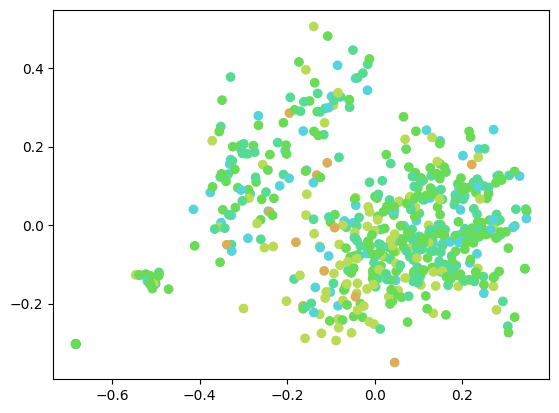

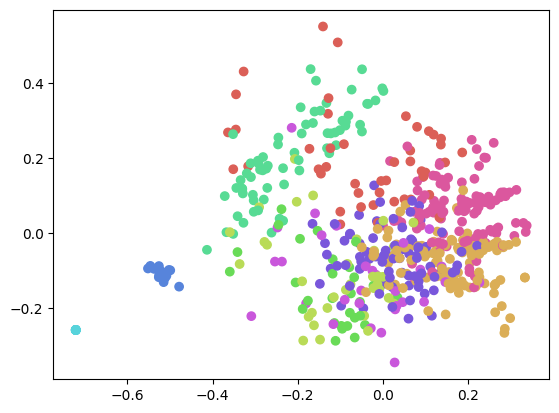

These two charts are not similar groupings - crash severity is likely not the primary dimension of characterization from the narratives

Explained variance: of the PCA step: 52.66%


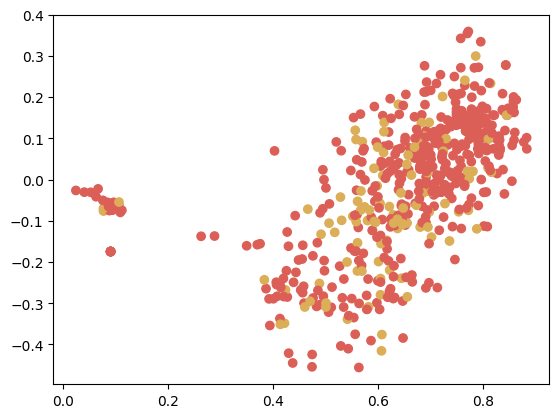

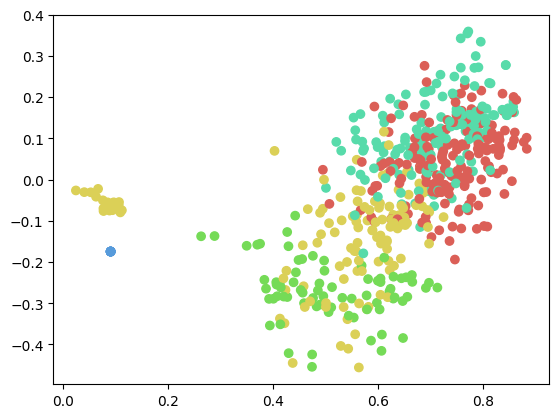

Counter({np.int32(4): 205, np.int32(0): 160, np.int32(1): 134, np.int32(3): 34, np.int32(2): 9})


In [116]:
# filtered_df = final_merged_data[final_merged_data['LSA_CLUSTER'] == 2][['concatenated_text']]
# filtered_df.to_csv('filtered_concatenated_text.csv', index=False)

In [314]:
# from imblearn.over_sampling import SMOTE
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Train SVC model on the resampled data
# svc = SVC()
# svc.fit(X_train_resampled, y_train_resampled)

# # Predict and evaluate
# y_pred = svc.predict(X_test)
# print(classification_report(y_test, y_pred))


ModuleNotFoundError: No module named 'imblearn'

In [318]:


# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train SVC model on the resampled data
svc = SVC()
svc.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))


# X_train = X_train['concatenated_text']
# X_test = X_test['concatenated_text']

ValueError: could not convert string to float: "INCIDENT REPORT PRINT DATE/TIME: 06/23/2023 13:17 LOGIN ID: FOREC INCIDENT: 2022-00219863 CLEVELAND DIVISION OF POLICE ORI NUMBER: OHCLPOOOO INCIDENT DATE/TIME: 7/31/2022 12:37:39 AM INCIDENT TYPE: NON FATAL PEDESTRAIN STRUCK LOCATION: E 47TH ST/ ST CLAIR AVE VENUE: CLEVELAND CLEVELAND OH 44103 PHONE NUMBER: ( TELEPHONE SOURCE: ANI/ALI REPORT REQUIRED: NO PRIORITY: 2 PRIOR HAZARDS: NO STATUS: ASSIGNED LE CASE NUMBER: NATURE OF CALL: NON FATAL ACCIDENT - PEDESTRIAN STRUCK UNIT/PERSONNEL UNIT PERSONNEL 3B31 C1863-CORRIGAN F1850-FREDRIKS 3C31 B1071-BETLEY 3S33 R1035-RIVERA PERSON(S) NO. ROLE NAME ADDRESS PHONE RACE SEX DOB 1 T-MOBILE USA, INC. VEHICLE(S) ROLE TYPE YEAR MAKE MODEL COLOR LICENSE STATE DISPOSITION(S) DISPOSITION COUNT OH1 CRASH REPORT 1 MADE/HELD HANDLED BY DETECTIVE 1 BUREAU PROPERTY DATE CODE TYPE MAKE MODEL DESCRIPTION TAG NO. ITEM NO. PAGE: 1 OF3 THIS DOCUMENT WAS CREATED BY AN APPLICATION THAT ISN’T LICENSED TO USE NOVAPDF. PURCHASE A LICENSE TO GENERATE PDF FILES WITHOUT THIS NOTICE.\n\nCALL COMMENTS COMMENTS FROM INTERGAPH 7/31/2022 00:37:39 - CLEVELAND 2 VEH MVA VEHICLE WAS GOING OVER 100MPH AND HIT THE ML ON THE MOTORCYCLE AND TOOK OFF 7/31/2022 00:37:40 - ** LOI SEARCH COMPLETED AT 07/31/22 00:37:40 7/31/2022 00:37:43 - TX TO EMS 7/31/2022 00:37:55 - GOING DOWN ST CLAIR, WB 7/31/2022 00:37:59 - UNK DESC OF THE VEHICLE 7/31/2022 00:38:06 - DUPLICATE EVENT:LOCATION = E 47TH ST/ST CLAIR AVE CLEV, CROSS STREET 1 = E 47TH ST, CROSS STREET 2 = ST CLAIR AVE, TYPE = NFHS - NON FATAL HIT SKIP ACCIDENT, SUBTYPE = 1M - 1M, CALLER NAME = ML CALLER, CALLER PH NUMBER CALLER ADDRESS = R 63RD ST - SW SECTOR CLEVELAND, CALL SOURCE = ANI/ALI, ALARM LEVEL = 0 7/31/2022 00:38:06 - CLEVELAND CALLER STS MC WAS HS BY A CAR THAT TOOK OFF TRANS TO EMS 7/31/2022 00:38:06 - END OF DUPLICATE EVENT DATA 7/31/2022 00:41:06 - ANOTHER CALL FROM EMS - MED 7 ENROUTE C/W MC VS LARGE TRUCK - EMS GIVING E 55/ST CLAIR AVE - CALLER TO EMS NO LONGER IN AREA /UNKN IF LARGE TRUCK W/BRIGHT LIGHTS STILL ON SCENE PER EMS - 216 258 9181 /// EMS ALSO ADV'G OF OTHER LOC FOR E 47/ST CLAIR AVE -- 7/31/2022 00:42:31 - ANOTHER CALL FROM EMS MEDIC 7 ENR 7/31/2022 00:43:07 - $24 ADVSD 7/31/2022 00:48:00 - ** EVENT TYPE CHANGED FROM NFH(1M) TO NFP(1M) AT: 07/31/22 00:48:00 ** >>>> BY: THOMAS WASHKO ON TERMINAL: PSPD-300 7/31/2022 00:48:16 - PER EMS THIS IS A CONFIRMED PED STRUCK 7/31/2022 00:49:44 - $24 ADVSD 7/31/2022 00:50:37 - MED 7 CONVEYING VICT TO METRO 7/31/2022 00:52:00 - $33/ZC ADVSD 7/31/2022 00:53:06 - THIS DOCUMENT WAS CREATED BY AN APPLICATION THAT ISN’T LICENSED TO USE NOVAPDF. PURCHASE A LICENSE TO GENERATE PDF FILES WITHOUT THIS NOTICE.\n\nB31 -- STILL FIGHTING TRAFFIC DOWNTOWN / PER S33 GO TO E 47/ST CLAIR 7/31/2022 00:53:17 - PER EMS ML IS STABLE 7/31/2022 00:55:05 - $33 DISREGARD B31 - NOTHING HERE ON SCENE 7/31/2022 00:55:13 - PREEMPT UNIT 3B31 7/31/2022 00:57:14 - C31 ENROUTE TO METRO TO CONF. W. PEDESTRIAN AND HANDLE OH 1 HIT SKIP 7/31/2022 01:13:08 - INADVERTENTLY CLOSED 7/31/2022 01:13:18 - ** EVENT 202200219863 HAS BEEN REOPENED AT: 07/31/22 01:13:18 ** 5>>> BY: JENIFER BEST ON TERMINAL: PSPD-286 7/31/2022 01:14:07 - ** LOI SEARCH COMPLETED AT 07/31/22 01:14:07 7/31/2022 03:08:52 - PREEMPT UNIT 3C31 7/31/2022 03:08:53 - EVENT 202200219863 DISPATCH ASSIGNED 7/31/2022 03:32:00 - IRR WILLIAMS OH-1 HS COMP EMS CONVEYED TO METRO THIS DOCUMENT WAS CREATED BY AN APPLICATION THAT ISN’T LICENSED TO USE NOVAPDF. PURCHASE A LICENSE TO GENERATE PDF FILES WITHOUT THIS NOTICE.\n\nREDACTION DATE: 6/23/2023 1:19:02 PM REDACTION LOG TOTAL NUMBER OF REDACTIONS IN DOCUMENT: 3 REDACTION REASONS BY PAGE PAGE REASON DESCRIPTION OCCURRENCES PURSUANT TO R.C. 149.43(A)(1)(MM), TELEPHONE NUMBERS FOR CRIME VICTIMS; WITNESSES TO A CRIME; VICTIMS WHO RECEIVED MEDICAL TREATMENT FOR INJURIES AS A RESULT TELEPHONE OF A MOTOR VEHICLE, AIRCRAFT, BOATING, NUMBERS AND/OR TROLLEY ACCIDENT CAUSED BY A MISDEMEANOR OR HIGHER VIOLATION OF THE OHIO REVISED CODE; AND/OR, PARTIES TO A MOTOR VEHICLE ACCIDENT, HAVE BEEN REDACTED. PURSUANT TO R.C. 149.43(A)(1)(MM), TELEPHONE NUMBERS FOR CRIME VICTIMS; WITNESSES TO A CRIME; VICTIMS WHO RECEIVED MEDICAL TREATMENT FOR INJURIES AS A RESULT 2 TELEPHONE OF A MOTOR VEHICLE, AIRCRAFT, BOATING, 2 NUMBERS AND/OR TROLLEY ACCIDENT CAUSED BY A MISDEMEANOR OR HIGHER VIOLATION OF THE OHIO REVISED CODE; AND/OR, PARTIES TO A MOTOR VEHICLE ACCIDENT, HAVE BEEN REDACTED.\n\nREDACTION DATE: 6/23/2023 1:19:02 PM REDACTION LOG REDACTION REASONS BY EXEMPTION A PAGES REASON DESCRIPTION (COUNT) PURSUANT TO R.C. 149.43(A)(1)(MM), TELEPHONE NUMBERS FOR CRIME VICTIMS; WITNESSES TO A CRIME; VICTIMS WHO RECEIVED MEDICAL TREATMENT FOR INJURIES AS A RESULT OF A | 1(1) TELEPHONE NUMBERS | MOTOR VEHICLE, AIRCRAFT, BOATING, AND/OR 2(2 TROLLEY ACCIDENT CAUSED BY A MISDEMEANOR OR HIGHER VIOLATION OF THE OHIO REVISED CODE; AND/OR, PARTIES TO A MOTOR VEHICLE ACCIDENT, HAVE BEEN REDACTED. WAPOLICE NARRATIVE \n\n E A / E / L. FT SPROTE WEL YUOCR ! AR MERO _MDSPT ALE. MERE PION RT SEE (OVER *) | THE VEHICCE THAT HIT HINA. UAIT® FLED APTER THE ACCIDEWT. PSER’ VEHICEE | OSCOA RED» WO WITWRSSES BAELE OR) _ | SCENE - OE"

In [312]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

models = [('multinomial_nb', MultinomialNB()),
          ('log_reg', LogisticRegression()),
          ('linear_svc', LinearSVC()),
          ('knn', KNeighborsClassifier(n_neighbors=5)),
          ('rf', RandomForestClassifier(n_estimators=5)),
]

In [313]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

for m_name, model in models:
    pipeline = Pipeline([('vec', TfidfVectorizer(tokenizer=CCR_Tokenizer)),(m_name,model)])
    pipeline.fit(X_train, y_train)
    test_y = pipeline.predict(X_test)
    print(classification_report(y_test, test_y, digits=6))

/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

           0   0.798246  1.000000  0.887805        91
           1   0.000000  0.000000  0.000000        23

    accuracy                       0.798246       114
   macro avg   0.399123  0.500000  0.443902       114
weighted avg   0.637196  0.798246  0.708686       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

              precision    recall  f1-score   support

           0   0.798246  1.000000  0.887805        91
           1   0.000000  0.000000  0.000000        23

    accuracy                       0.798246       114
   macro avg   0.399123  0.500000  0.443902       114
weighted avg   0.637196  0.798246  0.708686       114

              precision    recall  f1-score   support

           0   0.846154  0.967033  0.902564        91
           1   0.700000  0.304348  0.424242        23

    accuracy                       0.833333       114
   macro avg   0.773077  0.635690  0.663403       114
weighted avg   0.816667  0.833333  0.806061       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0   0.816514  0.978022  0.890000        91
           1   0.600000  0.130435  0.214286        23

    accuracy                       0.807018       114
   macro avg   0.708257  0.554228  0.552143       114
weighted avg   0.772831  0.807018  0.753672       114



/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0   0.816514  0.978022  0.890000        91
           1   0.600000  0.130435  0.214286        23

    accuracy                       0.807018       114
   macro avg   0.708257  0.554228  0.552143       114
weighted avg   0.772831  0.807018  0.753672       114



In [156]:
# from sklearn.model_selection import GridSearchCV

# vectorizer = TfidfVectorizer(tokenizer=CCR_Tokenizer)
# pipeline = Pipeline([('vec', vectorizer), ('model', model)])

# parameters = {'vec__ngram_range': ((1,1), (1,2)),
#               'vec__max_features':(500,1000),
#               'model__loss': ('hinge', 'squared_hinge'),
#               'model__C':(1,0.9)}

# grid_search = GridSearchCV(pipeline, parameters, verbose=1)
# grid_search.fit(X_train, y_train)

# test_y = grid_search.best_estimator_.predict(X_test)   
# print(classification_report(y_test, test_y, digits=6))


In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Define models
models = [
    # ('rf', RandomForestClassifier(n_estimators=100)),
    ('svc', SVC())
]

# Define pipeline (with placeholders for different models)
pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=CCR_Tokenizer)),
    ('model', RandomForestClassifier())  # Placeholder model
])

# Define parameters for both models
parameters = [
    {
        'model__n_estimators': [100, 200, 500],  # Number of trees
        'model__max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
        'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
        'model__min_samples_leaf': [1, 2, 4],  # Minimum number of samples in a leaf node
        'model__max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
        'model__bootstrap': [True, False],  # Whether bootstrap samples are used
        'model__class_weight': [None, 'balanced'],  # Adjust for class imbalance
    },
    {
        'model': [SVC()],
        'model__C': [0.9, 1],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto', 0.01, 0.1],
        'model__class_weight': ['balanced', None],
        'vec__ngram_range': [(1, 1), (1, 2)],
        'vec__max_features': [250, 500, 1000]
    }
]

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, verbose=1)
grid_search.fit(X_train, y_train)

# Get predictions and print report
test_y = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, test_y, digits=6))


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  war

              precision    recall  f1-score   support

           0   0.803922  0.987952  0.886486        83
           1   0.857143  0.230769  0.363636        26

    accuracy                       0.807339       109
   macro avg   0.830532  0.609361  0.625061       109
weighted avg   0.816617  0.807339  0.761770       109



In [162]:
from sklearn.metrics import classification_report

for i in range(len(grid_search.cv_results_['params'])):
    print(f"Model {i+1} with parameters: {para}")
    
    print(classification_report(y_test, test_y, digits=6))
    print("-" * 80)


NameError: name 'model_params' is not defined

In [32]:
final_merged_data

,CAD_ID,CAD_TEXT,OH1_TEXT,narrative,CRASH_SEVERITY_CD,U1_CONT_CIR_PRIMARY_CD,U1_PRECRASH_ACTION_CD,U1_TURN_CD,U1_TYPE_OF_UNIT_CD,U2_CONT_CIR_PRIMARY_CD,U2_PRECRASH_ACTION_CD,U2_TURN_CD,U2_TYPE_OF_UNIT_CD,concatenated_text,call_desc_stemmed
0,202000000930,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,NaN,A driver struck an adult crossing an intersect...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,incid report print date/tim : 05/20/2024 10:12...
1,202000001607,NaN,"WHILE UNIT1 WAS TURNING ONTO W44_, PEDESTRIAN ...",A driver of a commercial truck turned left and...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLICE NARRATIVE \n\n WHILE UNIT1 WAS TURNING ...,"polic narr while unit1 wa turn onto w44_ , ped..."
2,202000002596,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,NaN,A driver struck a person. The crash caused inj...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,incid report print date/tim : 05/20/2024 10:09...
3,202000002644,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,(JNIT 1 IS S/B ON E.99 STREET TURNING E/B (LEF...,A driver turned left and struck and killed an ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,incid report print date/tim : 05/20/2024 10:07...
4,202000003457,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,NaN,A driver struck an adult. The crash caused inj...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INCIDENT REPORT PRINT DATE/TIME: 05/20/2024 10...,incid report print date/tim : 05/20/2024 10:05...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,202300386537,PRINT DATE/TIME: LOGIN ID: INCIDENT DATE/TIME:...,UNKNOWN EVENTS,A driver of an SUV turned left and struck an a...,4.0,2.0,6.0,LT,99.0,1.0,14.0,NT,23.0,PRINT DATE/TIME: LOGIN ID: INCIDENT DATE/TIME:...,print date/tim : login id : incid date/tim : l...
2170,202300386861,INCIDENT REPORT PRINT DATE/TIME: 01/02/2024 10...,NaN,A driver of a transit bus struck a person.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INCIDENT REPORT PRINT DATE/TIME: 01/02/2024 10...,incid report print date/tim : 01/02/2024 10:12...
2171,202300387472,PRINT DATE/TIME: 01/05/2024 06:37 LOGIN ID: GR...,NaN,A driver struck a person.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRINT DATE/TIME: 01/05/2024 06:37 LOGIN ID: GR...,print date/tim : 01/05/2024 06:37 login id : g...
2172,202300388004,PRINT DATE/TIME: LOGIN ID: VECCHIOS INCIDENT: ...,NaN,A driver struck a person on a bicycle. The dri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PRINT DATE/TIME: LOGIN ID: VECCHIOS INCIDENT: ...,print date/tim : login id : vecchio incid : 20...


In [ ]:
from sklearn.decomposition import PCA
explained_var = []
for components in range(1, 10):
    pca = PCA(n_components=components)
    pca.fit(dtm.toarray())
    explained_var.append(pca.explained_variance_ratio_.sum())

In [84]:
from transformers import AutoTokenizer
import pandas as pd

# Initialize the bert_tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


def preprocess_text(text):
    if pd.isna(text):
        return ""
    return str(text)

def tokenize_texts(df, column_name, length=5000):
    return df[column_name].apply(lambda x: bert_tokenizer.encode(preprocess_text(x), truncation=True, padding='max_length', max_length=length))


final_merged_data['concat_text_tokenized'] = tokenize_texts(final_merged_data, 'concatenated_text')
final_merged_data['narrative_tokenized'] = tokenize_texts(final_merged_data, 'narrative', length=120)


/media/dzielinski06/HDD1/AI894 - Capstone/Complete Collision Recorder/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


final_merged_filtered = final_merged_data[final_merged_data['CRASH_SEVERITY_CD'].notna()]

# Assuming final_merged_data is available with narrative_tokenized and CRASH_SEVERITY_CD columns

# Step 1: Convert tokenized sequences to tensors
# We assume final_merged_data['narrative_tokenized'] contains the tokenized narrative (list of integers)
X = list(final_merged_filtered['narrative_tokenized'])
X = torch.tensor(X)  # Convert list of tokenized sequences to tensor

# Step 2: Encode the target variable (CRASH_SEVERITY_CD)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(final_merged_filtered['CRASH_SEVERITY_CD'])  # Encode labels
y = torch.tensor(y)

# Step 3: Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Step 5: Define a simple neural network model
class CrashSeverityPredictor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CrashSeverityPredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.embedding(x).mean(1)  # Average embeddings for simplicity
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model hyperparameters
vocab_size = tokenizer.vocab_size  # The vocabulary size from the tokenizer
embedding_dim = 128  # Size of the word embeddings
hidden_dim = 64  # Number of hidden units in the fully connected layer
output_dim = len(label_encoder.classes_)  # Number of classes (severity levels)

# Step 6: Initialize the model, loss function, and optimizer
model = CrashSeverityPredictor(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 7: Training the model
n_epochs = 1000  # Number of epochs

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(train_loader)}')

# Step 8: Evaluating the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch 1/1000, Loss: 1.4437211411339896
Epoch 2/1000, Loss: 1.3726663078580583
Epoch 3/1000, Loss: 1.336576087134225
Epoch 4/1000, Loss: 1.335417321750096
Epoch 5/1000, Loss: 1.3406597461019243
Epoch 6/1000, Loss: 1.3557339991841997
Epoch 7/1000, Loss: 1.3230759501457214
Epoch 8/1000, Loss: 1.3422232866287231
Epoch 9/1000, Loss: 1.3348524400166102
Epoch 10/1000, Loss: 1.3072764703205653
Epoch 11/1000, Loss: 1.3052522880690438
Epoch 12/1000, Loss: 1.3011147209576197
Epoch 13/1000, Loss: 1.298245906829834
Epoch 14/1000, Loss: 1.3004231027194433
Epoch 15/1000, Loss: 1.2857156651360648
Epoch 16/1000, Loss: 1.2900231650897436
Epoch 17/1000, Loss: 1.2723378198487418
Epoch 18/1000, Loss: 1.3024002739361353
Epoch 19/1000, Loss: 1.282689665045057
Epoch 20/1000, Loss: 1.2569061943462916
Epoch 21/1000, Loss: 1.2346308061054774
Epoch 22/1000, Loss: 1.2343708957944597
Epoch 23/1000, Loss: 1.2114672916276115
Epoch 24/1000, Loss: 1.2094976646559579
Epoch 25/1000, Loss: 1.2170061213629586
Epoch 26/1000

In [107]:
def predict():
    # Get the input data from the request
    input_data = "car struck a pedestrian at an intersection with some injury."

    # Tokenize the input data
    tokenized_input = tokenizer.encode(input_data, truncation=True, padding='max_length', max_length=100)
    tokenized_input = torch.tensor([tokenized_input])

    # Perform inference
    with torch.no_grad():
        outputs = model(tokenized_input)
        _, predicted = torch.max(outputs, 1)

    # Map the predicted label to the crash severity
    # crash_severity = 'Minor' if predicted.item() == 0 else 'Severe'

    # Return the prediction as a JSON response
    return {'prediction': predicted.item()}

predict()

{'prediction': 2}

In [85]:
# Calculate the length of each tokenized string for 'CAD_TEXT_tokenized'
final_merged_data['concat_text_tokenized_length'] = final_merged_data['concat_text_tokenized'].apply(len)
longest_concat_text_tokenized_length = final_merged_data['concat_text_tokenized_length'].max()

# Calculate the length of each tokenized string for 'narrative_tokenized'
final_merged_data['narrative_tokenized_length'] = final_merged_data['narrative_tokenized'].apply(len)
longest_narrative_tokenized_length = final_merged_data['narrative_tokenized_length'].max()

# Print the longest tokenized string lengths for each column
print("Longest 'concat_text_tokenized' length:", longest_concat_text_tokenized_length)
print("Longest 'narrative_tokenized' length:", longest_narrative_tokenized_length)


Longest 'concat_text_tokenized' length: 5000
Longest 'narrative_tokenized' length: 120


In [36]:
longest_string_row = final_merged_data[final_merged_data['CAD_TEXT_tokenized_length'] == longest_string_length]

print("Longest string length:", longest_string_length)
print("Longest tokenized string:", longest_string_row['CAD_TEXT].values[0])

Longest string length: 5320
Longest tokenized string: [101, 6140, 3058, 1013, 2051, 1024, 8833, 2378, 8909, 1024, 5043, 3058, 1013, 2051, 1024, 3295, 1024, 3042, 2193, 1024, 3189, 3223, 1024, 3188, 22010, 1024, 3393, 2553, 2193, 1024, 3131, 1013, 5073, 3131, 26424, 19317, 26424, 22907, 26424, 22407, 26424, 22022, 26424, 21619, 1018, 2497, 21926, 1018, 2497, 18827, 1018, 2497, 17788, 1018, 2497, 23833, 1018, 2278, 17465, 28048, 2549, 1018, 2278, 23833, 1018, 2094, 22407, 1018, 2094, 22025, 1018, 2546, 22025, 1018, 2290, 24434, 27519, 2549, 1018, 2140, 23352, 1018, 2072, 2581, 2581, 4466, 18827, 2711, 1006, 1055, 1007, 2053, 1012, 2535, 1015, 4316, 1006, 1055, 1007, 3931, 1024, 1064, 1997, 1023, 5043, 3189, 6021, 1013, 2654, 1013, 16798, 2549, 2340, 1024, 4601, 6769, 2015, 5043, 1024, 1022, 1013, 2539, 1013, 12609, 2184, 1024, 5709, 1024, 3486, 7610, 20317, 2692, 5637, 19980, 13642, 6044, 2821, 28015, 2692, 2629, 1064, 7026, 1064, 2053, 2053, 5073, 1040, 15136, 22407, 1011, 5203, 29491, 

In [56]:
def decode_tokenized(tokenized_list):
    return bert_tokenizer.decode(tokenized_list, skip_special_tokens=True)

# Apply the decoding function to the 'narrative_tokenized' column to get decoded text
final_merged_data['decoded_narrative'] = final_merged_data['narrative_tokenized'].apply(decode_tokenized)

# Split the decoded text into words, flatten the list, and find unique words
all_words = final_merged_data['decoded_narrative'].str.split().explode().unique()

# Print or return the unique words
print(all_words)

['a' 'driver' 'struck' 'an' 'adult' 'crossing' 'intersection.' 'the'
 'fled' 'scene.' 'of' 'commercial' 'truck' 'turned' 'left' 'and' 'person'
 'police' 'officers' 'did' 'not' 'ticket' 'driver.' 'person.' 'crash'
 'caused' 'injuries.' 'killed' 'fatal' 'adult.' 'passenger' 'car' 'on'
 'bicycle' 'ticketed' 'with' 'misdemeanor.' 'suv' 'vehicle' 'in' 'street.'
 'first' 'responders' 'could' 'locate' 'two' 'adults' 'duplicate' 'cad'
 '#' '201900386551' 'bicycle.' 'anyone' 'involved.' 'right' nan 'was'
 'involved' 'pickup' 'working' 'city' 'child' 'vehicle.' 'midblock' 'from'
 'bus' 'stop.' 'used' 'as' 'weapon.' 'van' 'adults.' 'hit' 'occurred' 'at'
 '130th' '&' 'buckeye' 'reversed' 'driveway.' 'child.' 'parking' 'area.'
 'midblock.' 'serious' 'all' 'parties' 'court' 'found' 'guilty.' 'hit.'
 'intersection' 'school' 'felony.' 'guilty' 'charges.' 'pushed' 'into'
 'third' 'party' 'transit' 'failed' 'to' 'appear' 'court.' 'standing'
 'sidewalk.' 'some' 'null.' 'using' 'wheelchair.' 'by' 'scooter

In [60]:
from collections import Counter

# Define a function to decode the tokenized sequence back to text
def decode_tokenized(tokenized_list):
    return bert_tokenizer.decode(tokenized_list, skip_special_tokens=True)

# Apply the decoding function to the 'narrative_tokenized' column to get decoded text
final_merged_data['decoded_narrative'] = final_merged_data['narrative_tokenized'].apply(decode_tokenized)

# Split the decoded text into words, flatten the list, and count the word frequencies
all_words = final_merged_data['decoded_narrative'].str.split().explode()
word_counter = Counter(all_words)

# Find the most common words
most_common_words = word_counter.most_common(50)  # Adjust the number for how many you want to see

# Print the most common words
print(most_common_words)

[('a', 3270), ('the', 2420), ('driver', 1867), ('struck', 1284), ('an', 1060), ('crash', 861), ('caused', 846), ('injuries.', 841), ('of', 840), ('fled', 482), ('scene.', 481), ('crossing', 478), ('not', 469), ('person', 438), ('car', 430), ('passenger', 419), ('intersection.', 383), ('on', 373), ('driver.', 357), ('adult', 324), ('could', 286), ('first', 284), ('responders', 284), ('locate', 284), ('police', 271), ('officers', 264), ('person.', 264), ('and', 250), ('suv', 226), ('turned', 191), ('did', 182), ('ticket', 179), ('in', 171), ('bicycle.', 165), ('bicycle', 162), ('involved.', 136), ('adult.', 128), ('child', 112), ('truck', 108), ('serious', 107), ('anyone', 105), ('left', 103), ('street.', 95), ('right', 89), ('pickup', 81), ('ticketed', 67), ('midblock.', 56), ('with', 55), ('was', 55), ('van', 40)]


In [ ]:
bert_bert_tokenizer = Autobert_tokenizer.from_pretrained("bert-base-uncased")
bert_vocab_size = len(bert_bert_tokenizer)